In this notebook, I do an initial glance at the data first, and continue with EDA.

- How clean is the data?
- What parameters do we have?
- How do they correlate with the target variable?

In [1]:
import pandas as pd
import sys, os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
import numpy as np

from src.load_data import read_from_dir_as_df, load_raw_data_from_dir, load_and_save_raw_weather_forecast
from src.data_preprocessing import contains_datetime_gaps

raw_data_dir = "../data/raw/"

# First glance

In [2]:
prices_df = read_from_dir_as_df(dir_path=os.path.join(raw_data_dir, "prices"))
prices_df.head(3)

,MTU (UTC),Area,Sequence,Day-ahead Price (EUR/MWh),Intraday Period (UTC),Intraday Price (EUR/MWh)
0,31/12/2023 23:00:00 - 31/12/2023 23:15:00,BZN|DE-LU,Sequence Sequence 1,0.10,NaN,NaN
1,31/12/2023 23:00:00 - 31/12/2023 23:15:00,BZN|DE-LU,Sequence Sequence 2,39.91,NaN,NaN
2,31/12/2023 23:15:00 - 31/12/2023 23:30:00,BZN|DE-LU,Sequence Sequence 1,0.10,NaN,NaN


In [3]:
prices_df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 172216 entries, 0 to 172215
Data columns (total 6 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   MTU (UTC)                  172216 non-null  object 
 1   Area                       172216 non-null  object 
 2   Sequence                   172216 non-null  object 
 3   Day-ahead Price (EUR/MWh)  172216 non-null  float64
 4   Intraday Period (UTC)      0 non-null       float64
 5   Intraday Price (EUR/MWh)   0 non-null       float64
dtypes: float64(3), object(3)
memory usage: 7.9+ MB


Data has 15 min frequency, and datetime column requires transformations. We will need only day-ahead price of the _sequence 2_. </br>
DE-LU - Deutschland-Luxembourg.

In [4]:
# check for unique categories in the 'Area' and 'Sequence' columns;
# we expect to have a single Area and 2 Sequences.
prices_df[["Area", "Sequence"]].drop_duplicates()

,Area,Sequence
0,BZN|DE-LU,Sequence Sequence 1
1,BZN|DE-LU,Sequence Sequence 2


In [5]:
cons_df = read_from_dir_as_df(dir_path=os.path.join(raw_data_dir, "consumption"))
cons_df.head(3)

,MTU (UTC),Area,Actual Total Load (MW),Day-ahead Total Load Forecast (MW)
0,01/01/2025 00:00 - 01/01/2025 00:15,BZN|DE-LU,47667.03,43302.48
1,01/01/2025 00:15 - 01/01/2025 00:30,BZN|DE-LU,47390.29,42905.27
2,01/01/2025 00:30 - 01/01/2025 00:45,BZN|DE-LU,47275.44,42544.53


In [6]:
cons_df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105216 entries, 0 to 105215
Data columns (total 4 columns):
 #   Column                              Non-Null Count   Dtype 
---  ------                              --------------   ----- 
 0   MTU (UTC)                           105216 non-null  object
 1   Area                                105216 non-null  object
 2   Actual Total Load (MW)              105212 non-null  object
 3   Day-ahead Total Load Forecast (MW)  105208 non-null  object
dtypes: object(4)
memory usage: 3.2+ MB


Here we already see some missing values in the actual load and load forecast. MTU requires similar transformations. </br>
Finally, moving on to the production data.

In [7]:
prod_df = read_from_dir_as_df(dir_path=os.path.join(raw_data_dir, "production"))
prod_df.head(3)

,MTU (UTC),Area,Production Type,Generation (MW)
0,01/01/2025 00:00:00 - 01/01/2025 00:15:00,BZN|DE-LU,Biomass,3811.77
1,01/01/2025 00:15:00 - 01/01/2025 00:30:00,BZN|DE-LU,Biomass,3763.22
2,01/01/2025 00:30:00 - 01/01/2025 00:45:00,BZN|DE-LU,Biomass,3759.65


In [8]:
prod_df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2209536 entries, 0 to 2209535
Data columns (total 4 columns):
 #   Column           Non-Null Count    Dtype 
---  ------           --------------    ----- 
 0   MTU (UTC)        2209536 non-null  object
 1   Area             2209536 non-null  object
 2   Production Type  2209536 non-null  object
 3   Generation (MW)  2209390 non-null  object
dtypes: object(4)
memory usage: 67.4+ MB


There are a lot of energy types. We will focus only on renewables, and most popular of them - solar and wind.

In [9]:
prod_df["Production Type"].unique()

array(['Biomass', 'Energy storage', 'Fossil Brown coal/Lignite',
       'Fossil Coal-derived gas', 'Fossil Gas', 'Fossil Hard coal',
       'Fossil Oil', 'Fossil Oil shale', 'Fossil Peat', 'Geothermal',
       'Hydro Pumped Storage', 'Hydro Run-of-river and poundage',
       'Hydro Water Reservoir', 'Marine', 'Nuclear', 'Other',
       'Other renewable', 'Solar', 'Waste', 'Wind Offshore',
       'Wind Onshore'], dtype=object)

As noticed, raw data requires initial preprocessing to remove unnecessary columns and transform MTUs. I will create a function to perform this task, and in the next paragraph we will continue with already preprocessed datasets. </br>
Lastly, we need to check weather forecast data for numerous weather variables. It is loaded using Open-Meteo API. </br>
As Germany is vast, I selected 10 specific coordinates for the time period from 01.01.2023 to 13.06.2025. Please refer to the code of the _load_and_save_raw_weather_forecast()_ function in order to explore it in more details. 

In [10]:
# if you haven't loaded the weather forecast data yet, uncomment the next line:
# load_and_save_raw_weather_forecast()
# otherwise, load it from the saved file:
weather_df = read_from_dir_as_df(dir_path=os.path.join(raw_data_dir, "weather_forecast"))
weather_df.head(3)

,datetime_utc,latitude,longitude,temperature_2m,dew_point_2m,relative_humidity_2m,rain,showers,snowfall,snow_depth,...,wind_speed_180m,wind_direction_10m,wind_direction_80m,wind_direction_180m,wind_direction_120m,wind_gusts_10m,direct_radiation,diffuse_radiation,shortwave_radiation,city
0,2023-01-01 00:00:00+00:00,52.52,13.4,15.952,7.694057,58.0,0.0,0.0,0.0,0.0,...,55.239770,222.13753,222.87889,225.26402,223.79404,44.280000,0.0,0.0,0.0,Berlin
1,2023-01-01 01:00:00+00:00,52.52,13.4,15.652,7.158457,57.0,0.0,0.0,0.0,0.0,...,55.608060,224.99990,226.43204,228.67460,227.12110,43.560000,0.0,0.0,0.0,Berlin
2,2023-01-01 02:00:00+00:00,52.52,13.4,15.352,6.620010,56.0,0.0,0.0,0.0,0.0,...,53.612206,225.74397,227.20262,229.35706,227.81563,46.079998,0.0,0.0,0.0,Berlin


In [11]:
weather_df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214800 entries, 0 to 214799
Data columns (total 28 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   datetime_utc          214800 non-null  object 
 1   latitude              214800 non-null  float64
 2   longitude             214800 non-null  float64
 3   temperature_2m        214800 non-null  float64
 4   dew_point_2m          214800 non-null  float64
 5   relative_humidity_2m  214800 non-null  float64
 6   rain                  214800 non-null  float64
 7   showers               214800 non-null  float64
 8   snowfall              214800 non-null  float64
 9   snow_depth            214800 non-null  float64
 10  cloud_cover           214800 non-null  float64
 11  cloud_cover_low       214800 non-null  float64
 12  cloud_cover_mid       214800 non-null  float64
 13  cloud_cover_high      214800 non-null  float64
 14  evapotranspiration    214800 non-null  float64
 15  

# EDA

### Prices & energy data

In this section we will work with already preprocessed data and explore it. </br>
We start with the dataset consisting of energy-related data. We will analyse weather forecast data separately, and add it to the dataset later in favor of an easier readability.

In [12]:
merged_data = load_raw_data_from_dir()
merged_data.head(3)

,start_ts_utc,end_ts_utc,da_price_eur_mwh,actual_load_mw,actual_generation_mw_solar,actual_generation_mw_wind_offshore,actual_generation_mw_wind_onshore
0,2022-12-31 23:00:00+00:00,2022-12-31 23:15:00+00:00,-5.17,NaN,NaN,NaN,NaN
1,2022-12-31 23:15:00+00:00,2022-12-31 23:30:00+00:00,-5.17,NaN,NaN,NaN,NaN
2,2022-12-31 23:30:00+00:00,2022-12-31 23:45:00+00:00,-5.17,NaN,NaN,NaN,NaN


As the data is time-series, let's start from analysing time-related components. </br>
We can already notice missing values, so data coming from 3 different sources is not perfectly alignted. We could investigate 'what' and 'why', but the simpliest solution would be to remove timestamps with missing values and ensure the cleaned dataset has a reasonable number of samples.

In [13]:
shape_nans = merged_data[merged_data.isna().any(axis=1)].shape
share_nans = shape_nans[0] / merged_data.shape[0]
print(f"Shape of rows with NaNs: {shape_nans}")
print(f"Share of rows with NaNs: {share_nans:.2%}")

Shape of rows with NaNs: (136, 7)
Share of rows with NaNs: 0.16%


The number of entries with missing values is very small. We can easily contibue without these samples.

In [14]:
merged_data.dropna(inplace=True)
print(f"Dataset after dropping NaNs: {merged_data.shape}")

Dataset after dropping NaNs: (85876, 7)


In [15]:
# view the first and the last timestamps in the dataset
print(f"First timestamp: {merged_data.start_ts_utc.min()}")
print(f"Last timestamp: {merged_data.start_ts_utc.max()}")

First timestamp: 2023-01-01 00:00:00+00:00
Last timestamp: 2025-06-13 15:45:00+00:00


Lastly, let's see if there are time gaps.

In [16]:
# returns False if there are no gaps
contains_datetime_gaps(
    df=merged_data,
    datetime_col_name="start_ts_utc",
    frequency="15M"
)

(False, DatetimeIndex([], dtype='datetime64[ns, UTC]', freq='15ME'))

Before we proceed, we need to ensure a correct type for each column. In particular, most columns that must be float are instead object. Let's fix it.

In [17]:
cols_to_convert = merged_data.columns[2:]
merged_data[cols_to_convert] = merged_data[cols_to_convert].astype(float)

Let's finally do some visualizations.

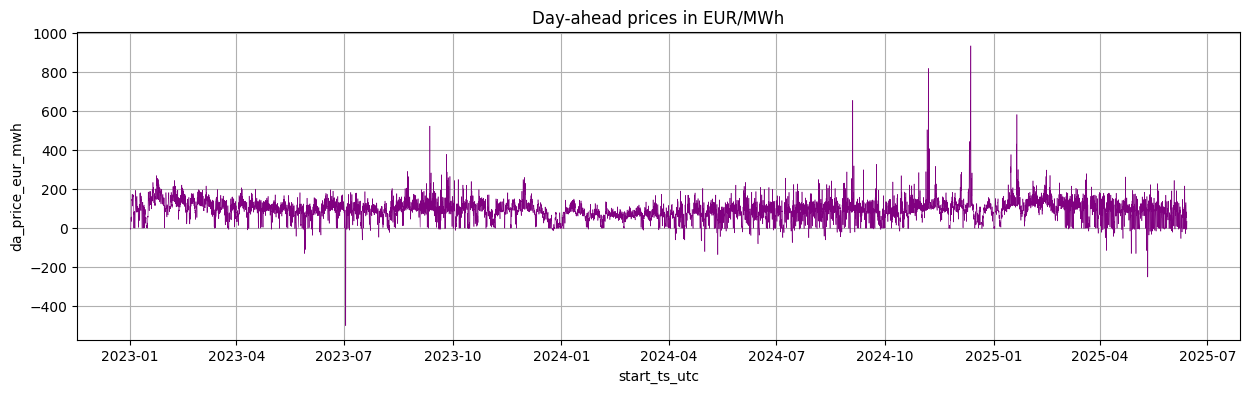

In [18]:
plt.figure(figsize=(15, 4))
sns.lineplot(
    data=merged_data,
    x="start_ts_utc",
    y="da_price_eur_mwh",
    linewidth=0.4,
    color="purple"
)
plt.grid()
plt.title("Day-ahead prices in EUR/MWh")
plt.show()

While prices have been mostly concentrated within 0-200 EUR range, we also observe extreme high prices, as well as low ones. </br>
As in this project I don't focus on outliers, and they seem quite valid (extremely loew neg price in July, when solar energy injection is high, as well as high prices during winter), I keep them.

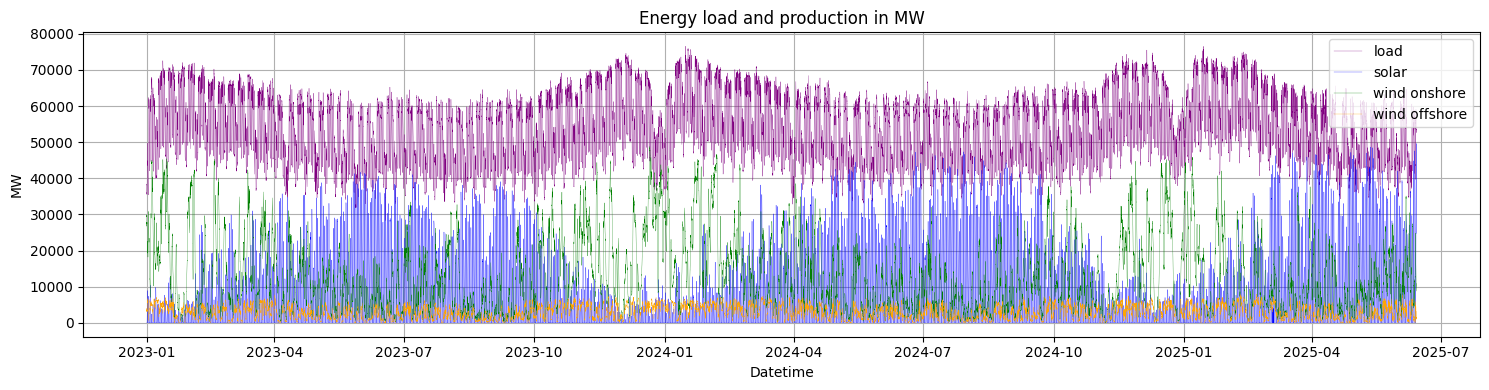

In [19]:
plt.figure(figsize=(15, 4))
sns.lineplot(
    data=merged_data,
    x="start_ts_utc",
    y="actual_load_mw",
    linewidth=0.2,
    color="purple",
    label="load"
)
sns.lineplot(
    data=merged_data,
    x="start_ts_utc",
    y="actual_generation_mw_solar",
    linewidth=0.2,
    color="blue",
    label="solar"
)
sns.lineplot(
    data=merged_data,
    x="start_ts_utc",
    y="actual_generation_mw_wind_onshore",
    linewidth=0.2,
    color="green",
    label="wind onshore"
)
sns.lineplot(
    data=merged_data,
    x="start_ts_utc",
    y="actual_generation_mw_wind_offshore",
    linewidth=0.2,
    color="orange",
    label="wind offshore"
)
plt.grid()
plt.ylabel("MW")
plt.xlabel("Datetime")
plt.legend()
plt.title("Energy load and production in MW")
plt.tight_layout()
plt.show()

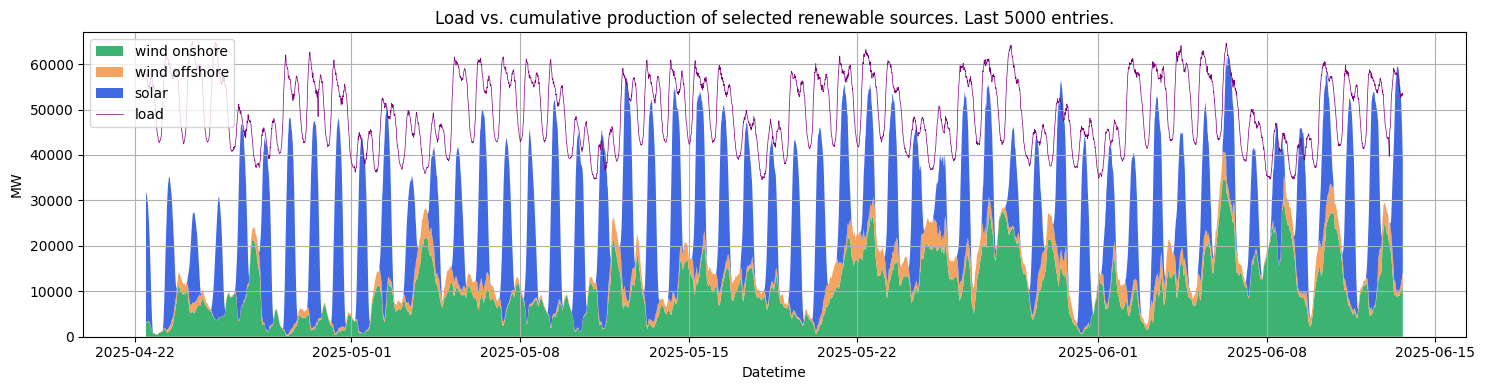

In [20]:
plt.figure(figsize=(15, 4))

stacked_df = merged_data[["start_ts_utc", "actual_generation_mw_solar", "actual_generation_mw_wind_offshore", "actual_generation_mw_wind_onshore"]].copy()
lim_num = 5000
stacked_df = stacked_df.iloc[-lim_num:, :]
plt.stackplot(
    stacked_df.start_ts_utc.values,
    stacked_df["actual_generation_mw_wind_onshore"].values,
    stacked_df["actual_generation_mw_wind_offshore"].values,
    stacked_df["actual_generation_mw_solar"].values,
    labels=["wind onshore", "wind offshore", "solar"],
    colors=["mediumseagreen", "sandybrown", "royalblue"],
    alpha=1,
    linewidth=1
)
sns.lineplot(
    data=merged_data.iloc[-lim_num:, :],
    x="start_ts_utc",
    y="actual_load_mw",
    linewidth=0.5,
    color="purple",
    label="load"
)

plt.title(f"Load vs. cumulative production of selected renewable sources. Last {lim_num} entries.")
plt.ylabel("MW")
plt.xlabel("Datetime")
plt.legend(loc="upper left")
plt.ylim(0, 67000)
plt.grid(True)
plt.tight_layout()
plt.show()

Based on visual inspection (and logic), solar energy production has strong daily and annual seasonality components. </br>
Wind production's seasonality is less obvious, but it also has an annual component with more energy produced during winter while resulting in less energy in summer. </br>
Energy consumption is a bit more complex. It has even more seasonal components:
* Besides obvious daily patterns, it demonstrates also intra-daily ones.
* Then, we see difference between workdays and weekends: during workdays the amount of consumed energy is higher.
* Additionally, it has the annual component: energy consumption growth during colder days, so it is higher in winter.
* And lastly, at the beginnings of 2024 and 2025 years we see a sudden drop in consumption. So, it seems that the Christmas and New Year holidays make people live more environmentally-friendly (at least, in Germany). :)

Let's observe the last point more closely.

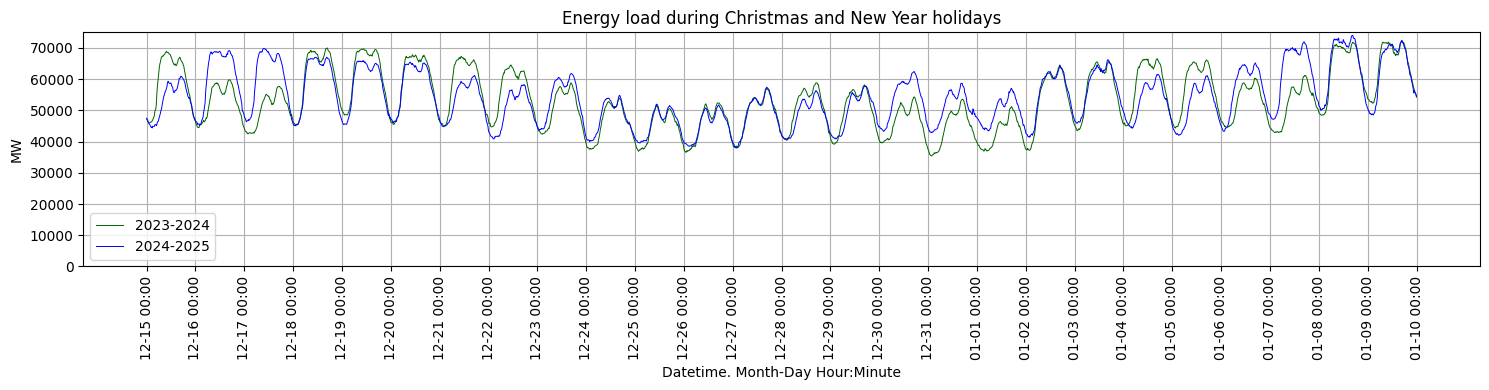

In [21]:
plt.figure(figsize=(15, 4))

data_2023 = merged_data[
    (merged_data.start_ts_utc >= "2023-12-15") &
    (merged_data.start_ts_utc <= "2024-01-10")
].copy()
data_2024 = merged_data[
    (merged_data.start_ts_utc >= "2024-12-15") &
    (merged_data.start_ts_utc <= "2025-01-10")
].copy()
data_2023["time_label"] = data_2023["start_ts_utc"].dt.strftime("%m-%d %H:%M")
data_2024["time_label"] = data_2024["start_ts_utc"].dt.strftime("%m-%d %H:%M")

sns.lineplot(
    data=data_2023,
    x="time_label",
    y="actual_load_mw",
    linewidth=0.7,
    color="darkgreen",
    label="2023-2024"
)
sns.lineplot(
    data=data_2024,
    x="time_label",
    y="actual_load_mw",
    linewidth=0.7,
    color="blue",
    label="2024-2025"
)
plt.grid()
plt.ylabel("MW")
plt.xlabel("Datetime. Month-Day Hour:Minute")
plt.ylim(0, 75000)
plt.xticks(ticks=plt.xticks()[0][::24*4], rotation=90)
plt.legend()
plt.title("Energy load during Christmas and New Year holidays")
plt.tight_layout()
plt.show()

Next, I will visualize linear trends. LinearRegression is a good tool for this task. </br>
Understanding trend, variability, and seasonal components are crucial for time-series. As modelling will be performed using ML, and not statistical approaches, I will account for time-series characteristics of the data accordingly. This topic will be covered later.

In [22]:
time_X = np.array(range(len(merged_data))).reshape(-1, 1)
price_trend = LinearRegression().fit(X=time_X, y=merged_data.da_price_eur_mwh.values).predict(X=time_X)
cons_trend = LinearRegression().fit(X=time_X, y=merged_data.actual_load_mw.values).predict(X=time_X)
solar_trend = LinearRegression().fit(X=time_X, y=merged_data.actual_generation_mw_solar.values).predict(X=time_X)
wind_off_trend = LinearRegression().fit(X=time_X, y=merged_data.actual_generation_mw_wind_offshore.values).predict(X=time_X)
wind_on_trend = LinearRegression().fit(X=time_X, y=merged_data.actual_generation_mw_wind_onshore.values).predict(X=time_X)

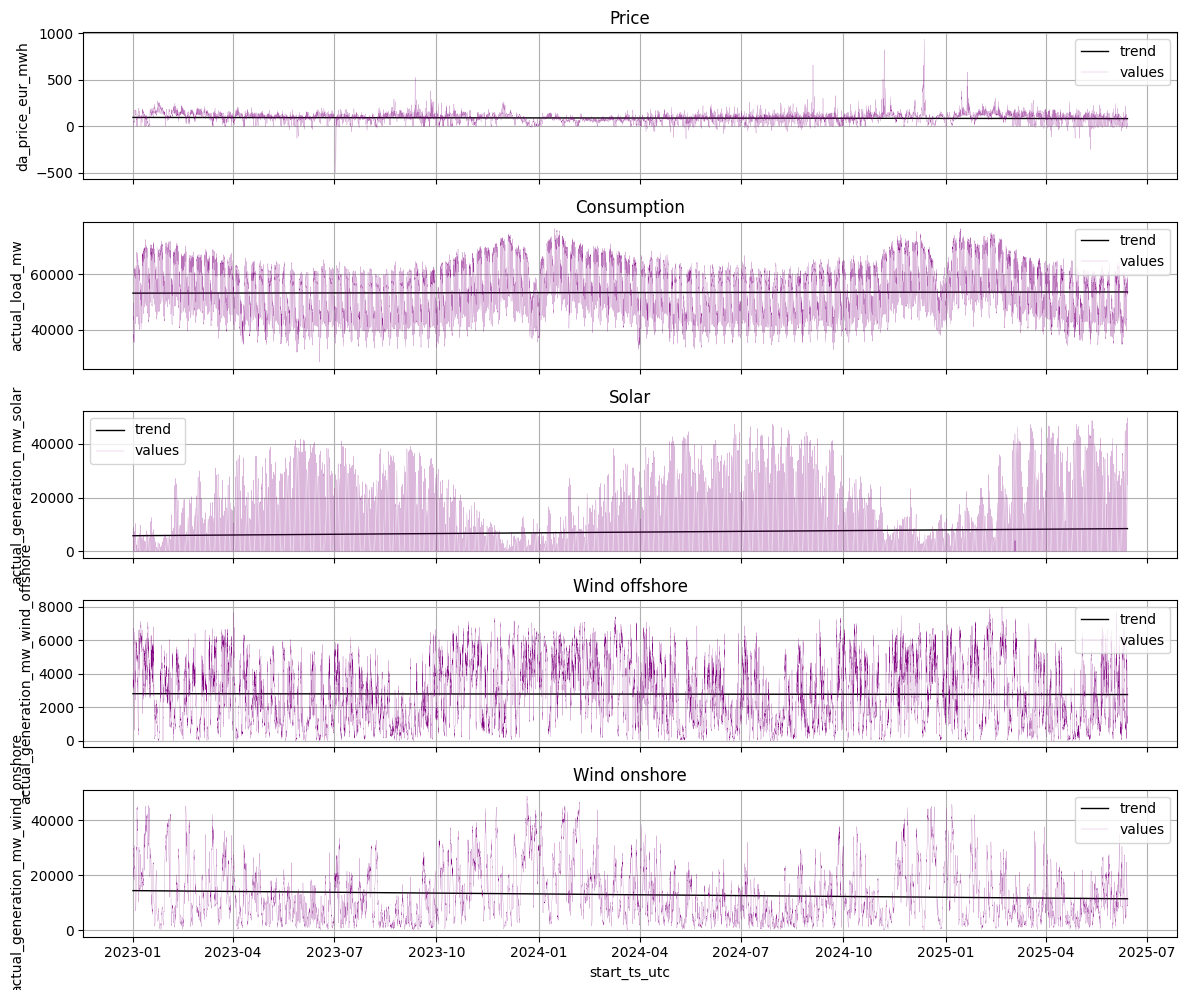

In [23]:
fig, axes = plt.subplots(5, 1, figsize=(12, 10), sharex=True)

# Price trend
sns.lineplot(ax=axes[0], x=merged_data.start_ts_utc, y=price_trend, color="black", label="trend", linewidth=1)
sns.lineplot(ax=axes[0], x=merged_data.start_ts_utc, y=merged_data.da_price_eur_mwh, color="purple", label="values", linewidth=0.1)
axes[0].set_title("Price")
axes[0].legend()
axes[0].grid(True)

# Consumption trend
sns.lineplot(ax=axes[1], x=merged_data.start_ts_utc, y=cons_trend, color="black", label="trend", linewidth=1)
sns.lineplot(ax=axes[1], x=merged_data.start_ts_utc, y=merged_data.actual_load_mw, color="purple", label="values", linewidth=0.1)
axes[1].set_title("Consumption")
axes[1].legend()
axes[1].grid(True)

# Solar trend
sns.lineplot(ax=axes[2], x=merged_data.start_ts_utc, y=solar_trend, color="black", label="trend", linewidth=1)
sns.lineplot(ax=axes[2], x=merged_data.start_ts_utc, y=merged_data.actual_generation_mw_solar, color="purple", label="values", linewidth=0.1)
axes[2].set_title("Solar")
axes[2].legend()
axes[2].grid(True)

# Wind offshore trend
sns.lineplot(ax=axes[3], x=merged_data.start_ts_utc, y=wind_off_trend, color="black", label="trend", linewidth=1)
sns.lineplot(ax=axes[3], x=merged_data.start_ts_utc, y=merged_data.actual_generation_mw_wind_offshore, color="purple", label="values", linewidth=0.1)
axes[3].set_title("Wind offshore")
axes[3].legend()
axes[3].grid(True)

# Wind onshore trend
sns.lineplot(ax=axes[4], x=merged_data.start_ts_utc, y=wind_on_trend, color="black", label="trend", linewidth=1)
sns.lineplot(ax=axes[4], x=merged_data.start_ts_utc, y=merged_data.actual_generation_mw_wind_onshore, color="purple", label="values", linewidth=0.1)
axes[4].set_title("Wind onshore")
axes[4].legend()
axes[4].grid(True)

plt.tight_layout()
plt.show()

Slight changes are visible, but 2.5 years of data seems to be a good choice and it is still 'fresh'. Anyway, just visual inspection is not the best way to exlore this component of time-series, but I believe that in the scope of the project we don't need to do more work on it.

### Weather forecast